In [1]:
import RAEAnglesUtilities as rae
from datetime import timedelta
import pandas as pd
from astropy.coordinates import SkyCoord, get_sun,FK4,get_body, EarthLocation

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os
import glob
import numpy as np
import astropy.units as u
from tqdm.notebook import tqdm

In [2]:
def append_if_valid_median_std(signal, median_list, std_list):
    median = np.nanmedian(signal)
    std = np.nanstd(signal)
    if not (np.isnan(median) or np.isnan(std)):
        median_list.append(median)
        std_list.append(std)

In [3]:
def append_if_valid_pair(
    pre_signal, post_signal,
    pre_median_list, pre_std_list,
    post_median_list, post_std_list
):
    pre_median = np.nanmedian(pre_signal)
    pre_std = np.nanstd(pre_signal)
    
    post_median = np.nanmedian(post_signal)
    post_std = np.nanstd(post_signal)
    # Check for NaNs or invalid values in both pre and post
    if (
        np.isfinite(pre_median) and np.isfinite(pre_std)
        and np.isfinite(post_median) and np.isfinite(post_std)
    ):
        pre_median_list.append(pre_median)
        pre_std_list.append(pre_std)
        
        post_median_list.append(post_median)
        post_std_list.append(post_std)

In [4]:
def occultationStatisticsIngressEgress(data, col='isVis', window=pd.Timedelta(minutes=10),antenn = 'rv2_coarse'):#edit this one to detect ingress and egress with variable time before and after
    freqs = data['frequency_band'].unique()
    stats = {}

    # Identify occultation periods
    occultation_changes = data[col].astype(int).diff()  # Detect changes in isVis
    start_times = data.index[(occultation_changes == -1)]  # False → True (start of occultation)
    end_times = data.index[(occultation_changes == 1)]  # True → False (end of occultation)

    # Ensure start_times and end_times align properly
    if len(end_times) > 0 and (len(start_times) == 0 or start_times[0] > end_times[0]):
        end_times = end_times[1:]  # Remove first end_time if it comes before any start_time

    if len(start_times) > len(end_times):
        start_times = start_times[:-1]  # Remove extra start_time if unmatched

    # Filter occultation periods that are at least 2 minutes long
    valid_pairs = [(s, e) for s, e in zip(start_times, end_times) if (e - s) >= pd.Timedelta(minutes=2)]
    
    # **Fix for empty valid_pairs**  
    if valid_pairs:
        start_times, end_times = zip(*valid_pairs)
    else:
        start_times, end_times = [], []

    # Loop over frequency bands
    for freq in tqdm(freqs, desc="Processing frequencies"):
        freq_data = data[data['frequency_band'] == freq]
        ingress_stats = {'preMedian': [], 'preStd': [], 'postMedian': [],'postStd': []}
        egress_stats = {'preMedian': [], 'preStd': [], 'postMedian': [],'postStd': []}

        for start, end in zip(start_times, end_times):
            pre_ingress = freq_data.loc[(freq_data.index >= start - window) & 
                                       (freq_data.index < start) & 
                                       (freq_data[col] == True)]
            
            post_ingress = freq_data.loc[(freq_data.index >= start) & 
                                       (freq_data.index < start+window) & 
                                       (freq_data[col] == False)]
            
            pre_egress = freq_data.loc[(freq_data.index > end-window) & 
                                        (freq_data.index <= end) & 
                                        (freq_data[col] == False)]
            post_egress = freq_data.loc[(freq_data.index > end) & 
                                        (freq_data.index <= end + window) & 
                                        (freq_data[col] == True)]
                        
            if pre_ingress.empty or post_ingress.empty:
                print(f"Skipping empty ingress period: {start} to {end}")
                continue
            if post_egress.empty or pre_egress.empty:
                print(f"Skipping empty non occult: {start} to {end}")
                continue
            # Extract signal values
            pre_ingress_data = pre_ingress[antenn]
            post_ingress_data = post_ingress[antenn]
            
            pre_egress_data = pre_egress[antenn]
            post_egress_data = post_egress[antenn]
            
            pre_ingress_sig = rae.sigmaClip(pre_ingress_data,n=5)
            post_ingress_sig = rae.sigmaClip(post_ingress_data,n=5)

            pre_egress_sig = rae.sigmaClip(pre_egress_data,n=5)
            post_egress_sig = rae.sigmaClip(post_egress_data,n=5)
            
            
            # Compute statistics
            append_if_valid_median_std(pre_ingress_sig, ingress_stats['preMedian'], ingress_stats['preStd'])
            append_if_valid_median_std(post_ingress_sig, ingress_stats['postMedian'], ingress_stats['postStd'])
            append_if_valid_median_std(pre_egress_sig, egress_stats['preMedian'], egress_stats['preStd'])
            append_if_valid_median_std(post_egress_sig, egress_stats['postMedian'], egress_stats['postStd'])



        
        # Store statistics for this frequency band
        stats[freq] = {
            'ingress': ingress_stats,
            'egress': egress_stats
        }

    return stats

In [5]:
def occultationStatisticsIngressEgressPairs(data, col='isVis', window=pd.Timedelta(minutes=10),antenn = 'rv2_coarse'):
    #this one insures that the pairs are in sync, since in the other function the pre or post could be nan one time while the other isnt, leading to an error
    freqs = data['frequency_band'].unique()
    stats = {}

    # Identify occultation periods
    occultation_changes = data[col].astype(int).diff()  # Detect changes in isVis
    start_times = data.index[(occultation_changes == -1)]  # False → True (start of occultation)
    end_times = data.index[(occultation_changes == 1)]  # True → False (end of occultation)

    # Ensure start_times and end_times align properly
    if len(end_times) > 0 and (len(start_times) == 0 or start_times[0] > end_times[0]):
        end_times = end_times[1:]  # Remove first end_time if it comes before any start_time

    if len(start_times) > len(end_times):
        start_times = start_times[:-1]  # Remove extra start_time if unmatched

    # Filter occultation periods that are at least 2 minutes long
    valid_pairs = [(s, e) for s, e in zip(start_times, end_times) if (e - s) >= pd.Timedelta(minutes=2)]
    
    # **Fix for empty valid_pairs**  
    if valid_pairs:
        start_times, end_times = zip(*valid_pairs)
    else:
        start_times, end_times = [], []

    # Loop over frequency bands
    for freq in tqdm(freqs, desc="Processing frequencies"):
        freq_data = data[data['frequency_band'] == freq]
        ingress_stats = {'preMedian': [], 'preStd': [], 'postMedian': [],'postStd': []}
        egress_stats = {'preMedian': [], 'preStd': [], 'postMedian': [],'postStd': []}

        for start, end in zip(start_times, end_times):
            pre_ingress = freq_data.loc[(freq_data.index >= start - window) & 
                                       (freq_data.index < start) & 
                                       (freq_data[col] == True)]
            
            post_ingress = freq_data.loc[(freq_data.index >= start) & 
                                       (freq_data.index < start+window) & 
                                       (freq_data[col] == False)]
            
            pre_egress = freq_data.loc[(freq_data.index > end-window) & 
                                        (freq_data.index <= end) & 
                                        (freq_data[col] == False)]
            post_egress = freq_data.loc[(freq_data.index > end) & 
                                        (freq_data.index <= end + window) & 
                                        (freq_data[col] == True)]
                        
            if pre_ingress.empty or post_ingress.empty:
                print(f"Skipping empty ingress period: {start} to {end}")
                continue
            if post_egress.empty or pre_egress.empty:
                print(f"Skipping empty non occult: {start} to {end}")
                continue
            # Extract signal values
            pre_ingress_data = pre_ingress[antenn]
            post_ingress_data = post_ingress[antenn]
            
            pre_egress_data = pre_egress[antenn]
            post_egress_data = post_egress[antenn]
            
            pre_ingress_sig = rae.sigmaClip(pre_ingress_data,n=5)
            post_ingress_sig = rae.sigmaClip(post_ingress_data,n=5)

            pre_egress_sig = rae.sigmaClip(pre_egress_data,n=5)
            post_egress_sig = rae.sigmaClip(post_egress_data,n=5)
            
            
            # Compute statistics
            append_if_valid_pair(pre_ingress_sig, post_ingress_sig,
                                ingress_stats['preMedian'], ingress_stats['preStd'],
                                ingress_stats['postMedian'], ingress_stats['postStd'])

            append_if_valid_pair(pre_egress_sig, post_egress_sig,
                                egress_stats['preMedian'], egress_stats['preStd'],
                                egress_stats['postMedian'], egress_stats['postStd'])



        
        # Store statistics for this frequency band
        stats[freq] = {
            'ingress': ingress_stats,
            'egress': egress_stats
        }

    return stats

In [6]:
# Load the file to inspect its contents
filename = r"/global/cfs/projectdirs/m4895/RAE2Data/interpolatedRAE2MasterFile.csv"

rawData = pd.read_csv(filename)
data = rawData
data['time'] = pd.to_datetime(data['time'])
data.drop('Unnamed: 0',axis=1,inplace=True)
data.set_index('time',inplace=True)
start_date = pd.to_datetime("1974-01-01 14:00")
end_date = pd.to_datetime("1975-12-31 16:00")

# Selecting rows within the date range
earthOccult = data[(data.index >= start_date) & (data.index <= end_date)].copy()


In [7]:
earthOccult[f'JupiterAngle'] = rae.solarSystemAngles(earthOccult,'Jupiter')
earthOccult[f'JupiterVis'] = rae.isVisible(earthOccult, earthOccult[f'JupiterAngle'])

/global/u2/a/afahs/RAE2/RAEAnglesUtilities.py:134: RuntimeWarning: invalid value encountered in divide
  dec = np.arcsin(z / r)
/global/u2/a/afahs/RAE2/RAEAnglesUtilities.py:160: RuntimeWarning: divide by zero encountered in divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
/global/u2/a/afahs/RAE2/RAEAnglesUtilities.py:160: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


In [8]:
#stats = occultationStatisticsIngressEgress(earthOccult,'Fornax-AVis',window = pd.Timedelta(minutes = 5),antenn = 'rv2_coarse')

In [9]:
stats = occultationStatisticsIngressEgressPairs(earthOccult,'JupiterVis',window = pd.Timedelta(minutes = 5),antenn = 'rv2_coarse')

Processing frequencies:   0%|          | 0/9 [00:00<?, ?it/s]

Skipping empty non occult: 1974-01-03 23:28:07.275000 to 1974-01-04 00:00:08.380000
Skipping empty non occult: 1974-01-05 23:33:20.944000 to 1974-01-06 00:10:51.096000
Skipping empty ingress period: 1974-01-09 12:56:40.713000 to 1974-01-09 13:00:04.238000
Skipping empty ingress period: 1974-01-10 18:30:58.301000 to 1974-01-10 18:34:17.977000
Skipping empty non occult: 1974-01-11 05:33:13.726000 to 1974-01-12 00:00:06.382000
Skipping empty ingress period: 1974-01-12 14:51:30.307000 to 1974-01-12 14:55:22.629000
Skipping empty ingress period: 1974-05-05 18:59:56.477000 to 1974-05-05 19:45:57.313000
Skipping empty ingress period: 1974-05-06 02:32:00.621000 to 1974-05-06 03:09:48.028000
Skipping empty ingress period: 1974-05-07 08:29:31.913000 to 1974-05-07 08:45:18.437000
Skipping empty non occult: 1974-05-07 22:50:10.889000 to 1974-05-07 23:45:57.248000
Skipping empty non occult: 1974-05-08 06:14:05.475000 to 1974-05-08 07:03:10.553000
Skipping empty non occult: 1974-05-08 13:37:59.94000

/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_

Skipping empty non occult: 1974-06-08 13:49:28.249000 to 1974-06-08 14:00:44.047000
Skipping empty non occult: 1974-07-05 13:34:02.618000 to 1974-07-05 14:44:14.953000
Skipping empty ingress period: 1974-07-05 21:10:32.559000 to 1974-07-05 21:25:13.830000
Skipping empty non occult: 1974-07-06 11:45:54.379000 to 1974-07-06 12:19:18.805000
Skipping empty non occult: 1974-07-06 19:09:55.629000 to 1974-07-06 20:21:05.139000
Skipping empty ingress period: 1974-07-07 02:46:06.128000 to 1974-07-07 03:01:08.540000
Skipping empty non occult: 1974-07-11 02:45:57.819000 to 1974-07-11 04:01:11.585000
Skipping empty ingress period: 1974-07-15 06:59:13.111000 to 1974-07-15 07:15:28.474000
Skipping empty ingress period: 1974-07-18 05:08:47.463000 to 1974-07-18 05:42:08.069000
Skipping empty ingress period: 1974-07-19 10:42:33.116000 to 1974-07-19 11:17:48.986000
Skipping empty non occult: 1974-07-20 01:22:25.436000 to 1974-07-20 06:40:07.196000
Skipping empty non occult: 1974-07-20 12:28:16.796000 to

In [ ]:
def plotIngressEgressHistograms(
    data,
    *,
    use_std_weights=False,
    min_bin_percentage=None,
    palette=("tab:blue", "tab:orange"),
    suptitle=None,
    save_path=None
):
    """
    data = {
        'ingress': {
            'preMedian': [...], 'preStd': [...],
            'postMedian': [...], 'postStd': [...]
        },
        'egress': {
            ...
        }
    }
    """
    labels = ['ingress', 'egress']
    n_panels = len(labels)

    # Handle uniform or per-panel filter thresholds
    if isinstance(min_bin_percentage, (int, float)) or min_bin_percentage is None:
        min_bin_percentage = [min_bin_percentage] * n_panels
    elif len(min_bin_percentage) != n_panels:
        raise ValueError("min_bin_percentage must have one entry per label")

    fig, axes = plt.subplots(1, n_panels, figsize=(7 * n_panels, 5), constrained_layout=True)
    if n_panels == 1:
        axes = [axes]

    for ax, label, pct in zip(axes, labels, min_bin_percentage):
        pre_median = np.asarray(data[label]['preMedian'])
        pre_std    = np.asarray(data[label]['preStd'])
        post_median = np.asarray(data[label]['postMedian'])
        post_std    = np.asarray(data[label]['postStd'])
        
        # Optional filter on upper medians
        if pct is not None:
            threshold_pre = np.percentile(pre_median, 100 * (1 - pct))
            threshold_post = np.percentile(post_median, 100 * (1 - pct))
            keep_pre  = pre_median  <= threshold_pre
            keep_post = post_median <= threshold_post
            pre_median,  pre_std  = pre_median[keep_pre],  pre_std[keep_pre]
            post_median, post_std = post_median[keep_post], post_std[keep_post]
        
        # Define weights
        pre_weights  = 1 / (pre_std  + 1e-9) if use_std_weights else None
        post_weights = 1 / (post_std + 1e-9) if use_std_weights else None

        # Define bins on combined data
        all_medians = np.concatenate([pre_median, post_median])
        bins = np.histogram_bin_edges(all_medians, bins=40)

        # Weighted, density-normalized histograms
        pre_counts, _  = np.histogram(pre_median,  bins=bins, weights=pre_weights,  density=True)
        post_counts, _ = np.histogram(post_median, bins=bins, weights=post_weights, density=True)

        # Normalize to peak=1 so both shapes are comparable
        if pre_counts.max() > 0:
            pre_counts /= pre_counts.max()
        if post_counts.max() > 0:
            post_counts /= post_counts.max()

        width = np.diff(bins)
        ax.bar(bins[:-1], pre_counts, width=width, align='edge',
               alpha=0.65, color=palette[0], edgecolor='black', label='Pre')
        ax.bar(bins[:-1], post_counts, width=width, align='edge',
               alpha=0.65, color=palette[1], edgecolor='black', label='Post')

        # Cosmetics
        ax.set_title(f"{label.capitalize()} histogram")
        ax.set_xlabel("Median signal")
        ax.set_ylabel("Normalized count")
        ax.set_yticks(np.linspace(0, 1, 6))
        ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)
        ax.xaxis.get_offset_text().set_visible(False)
        ax.legend(frameon=False, fontsize=9)

    if suptitle:
        fig.suptitle(suptitle, fontsize=16, y=1.02)

    if save_path:
        fig.savefig(save_path, bbox_inches="tight")
        print(f"Saved → {save_path}")

    plt.show()

: 

In [ ]:
def plotIngressEgressDiffHistograms(
    data,
    *,
    use_std_weights=False,
    min_bin_percentage=None,
    palette=("tab:green",),
    suptitle=None,
    save_path=None,
    n_bins=40          # keep even so 0 is a boundary
):
    import numpy as np
    import matplotlib.pyplot as plt

    labels = ['ingress', 'egress']
    n_panels = len(labels)

    # allow scalar or per‑panel percentile thresholds
    if isinstance(min_bin_percentage, (int, float)) or min_bin_percentage is None:
        min_bin_percentage = [min_bin_percentage] * n_panels
    elif len(min_bin_percentage) != n_panels:
        raise ValueError("min_bin_percentage must have one entry per label")

    # ---------- PASS 1: filter & store diffs per label -----------------
    filtered_diffs = {}
    filtered_pre_std = {}
    filtered_post_std = {}
    for label, pct in zip(labels, min_bin_percentage):
        pre_med  = np.asarray(data[label]['preMedian'])
        post_med = np.asarray(data[label]['postMedian'])
        pre_std  = np.asarray(data[label]['preStd'])
        post_std = np.asarray(data[label]['postStd'])

        n = min(len(pre_med), len(post_med))
        pre_med, post_med = pre_med[:n], post_med[:n]
        pre_std, post_std = pre_std[:n], post_std[:n]

        # Option C percentile mask BEFORE diff calculation
        if pct is not None:
            max_meds = np.maximum(pre_med, post_med)
            thr = np.percentile(max_meds, 100 * (1 - pct))
            keep = max_meds <= thr
            pre_med, post_med = pre_med[keep], post_med[keep]
            pre_std, post_std = pre_std[keep], post_std[keep]

        diff = post_med - pre_med
        filtered_diffs[label] = diff
        filtered_pre_std[label]  = pre_std
        filtered_post_std[label] = post_std

    # ---------- PASS 2: build common bin edges from the *filtered* data -
    all_diff = np.hstack(list(filtered_diffs.values()))
    max_range = np.max(np.abs(all_diff))
    bin_edges = np.linspace(-max_range, max_range, n_bins + 1)   # 0 on an edge

    # ---------- PASS 3: plot -------------------------------------------
    fig, axes = plt.subplots(1, n_panels, figsize=(7 * n_panels, 5), constrained_layout=True)
    if n_panels == 1:
        axes = [axes]

    for ax, label in zip(axes, labels):
        diff = filtered_diffs[label]
        pre_s = filtered_pre_std[label]
        post_s = filtered_post_std[label]

        weights = (1 / (np.sqrt(pre_s**2 + post_s**2) + 1e-9)) if use_std_weights else None
        counts, _ = np.histogram(diff, bins=bin_edges, weights=weights, density=True)
        if counts.max() > 0:
            counts /= counts.max()

        ax.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge',
               alpha=0.75, color=palette[0], edgecolor='black',
               label=f'{label.capitalize()} Diff')
        ax.set_title(f"{label.capitalize()} (Post − Pre) Histogram")
        ax.set_xlabel("Post − Pre median difference")
        ax.set_ylabel("Normalized count")
        ax.set_yticks(np.linspace(0, 1, 6))
        ax.axvline(0, color='gray', linestyle='--', lw=1)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)
        ax.legend(frameon=False, fontsize=9)

    if suptitle:
        fig.suptitle(suptitle, fontsize=16, y=1.02)
    if save_path:
        fig.savefig(save_path, bbox_inches="tight")
        print(f"Saved → {save_path}")

    plt.show()


: 

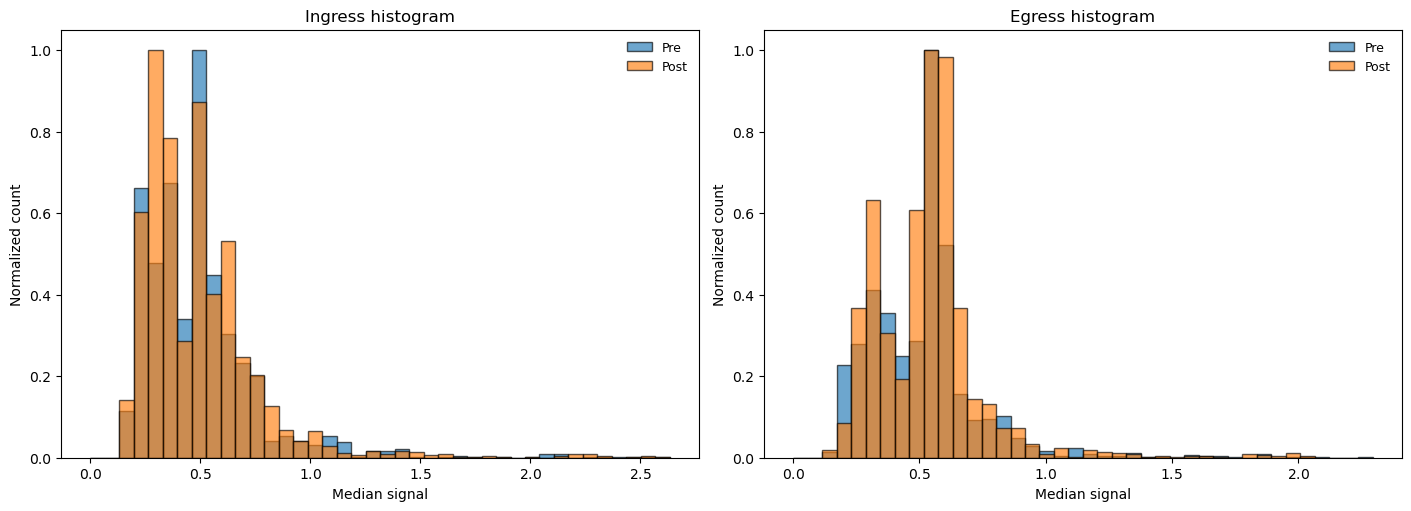

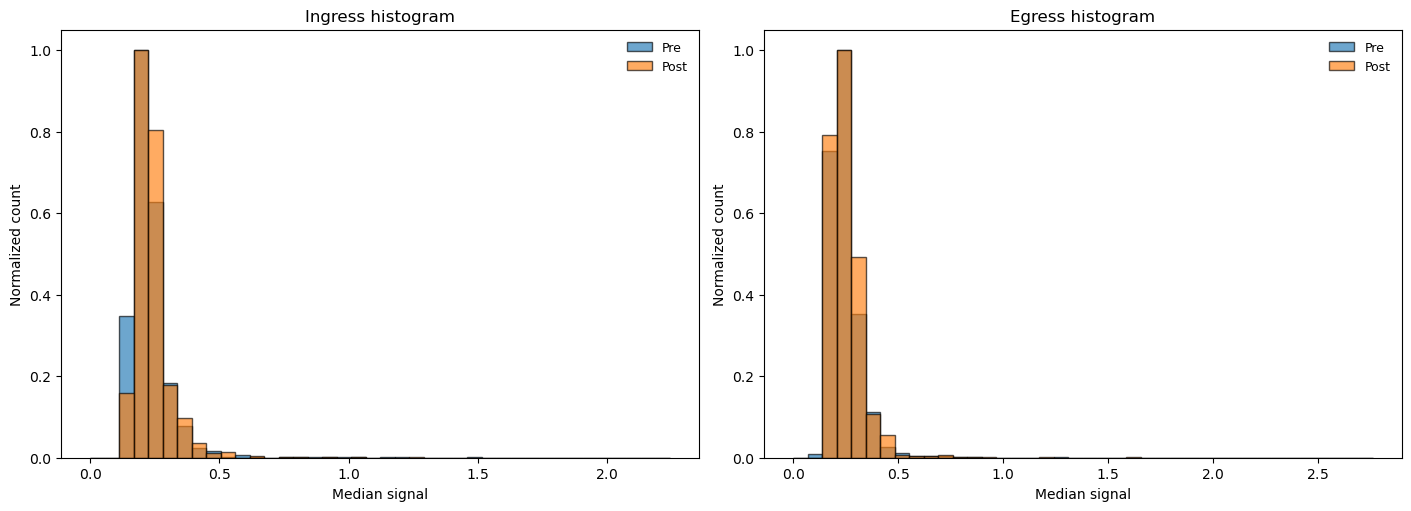

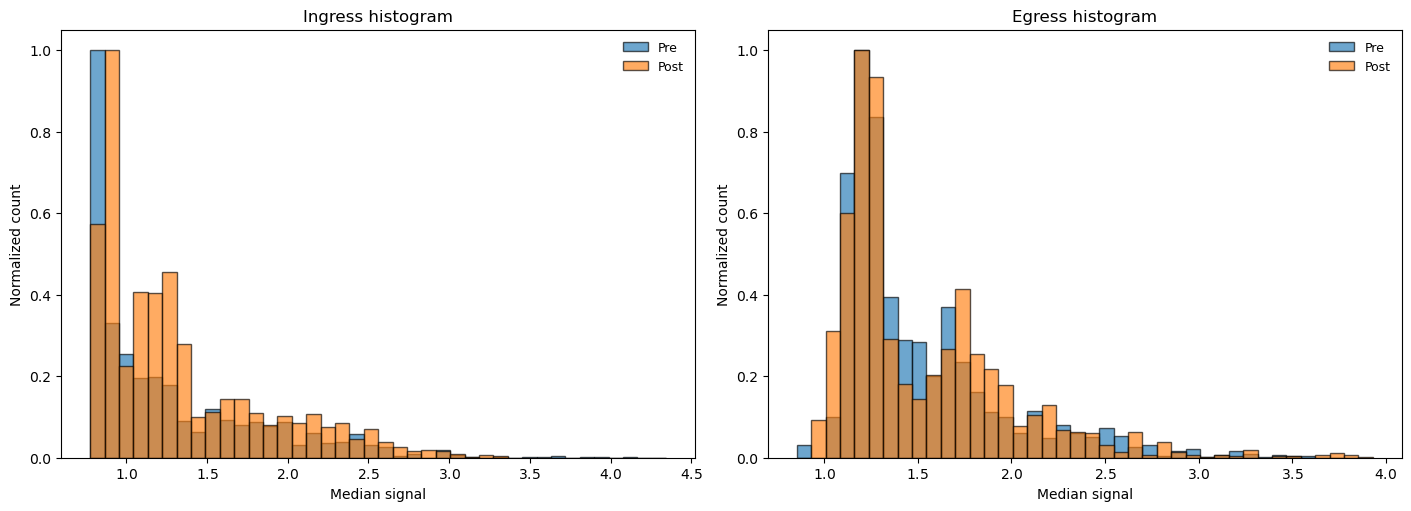

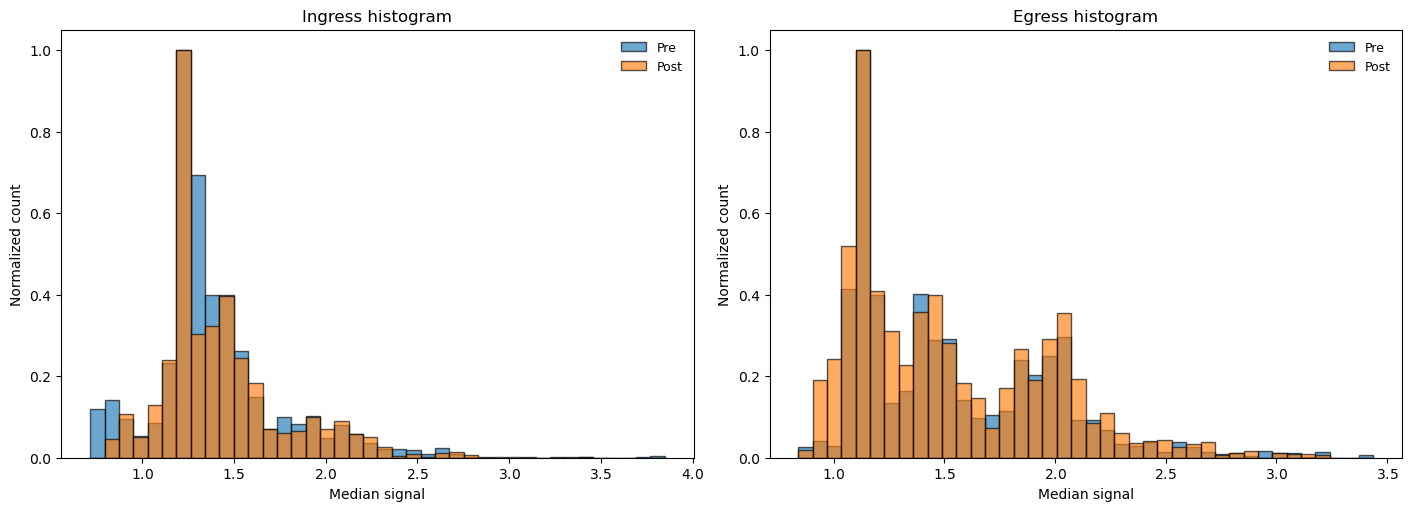

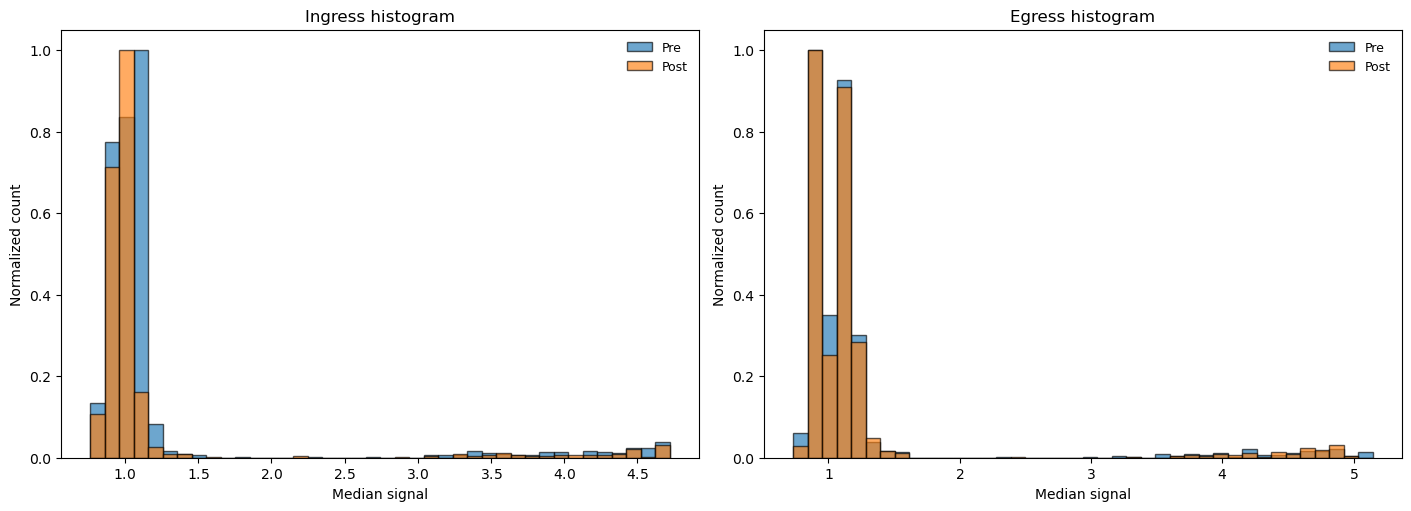

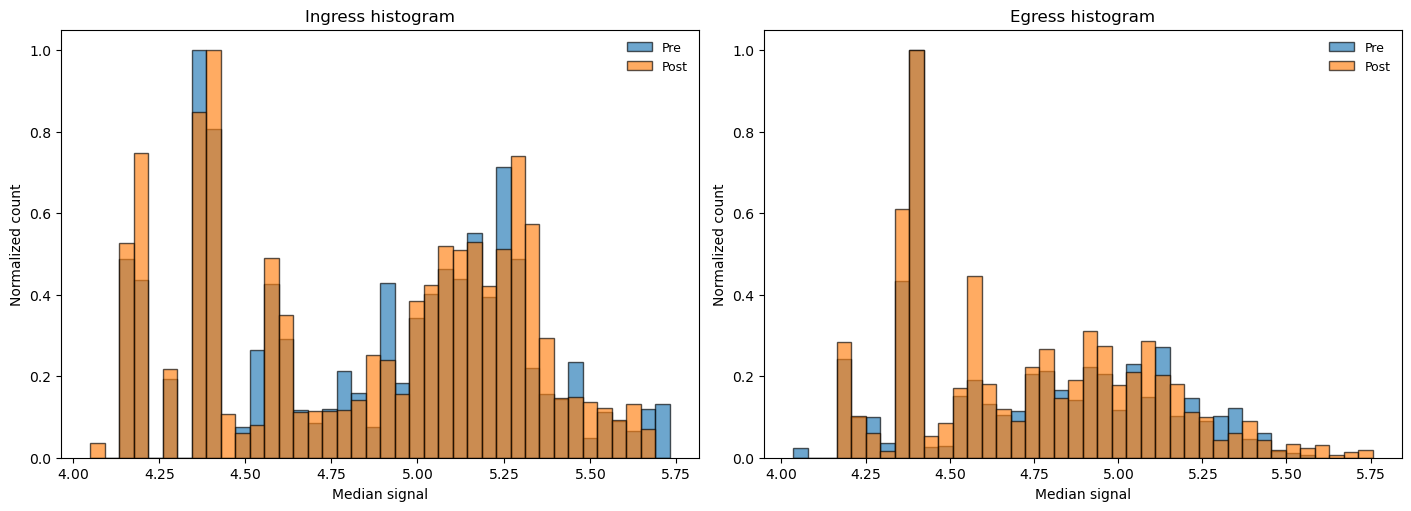

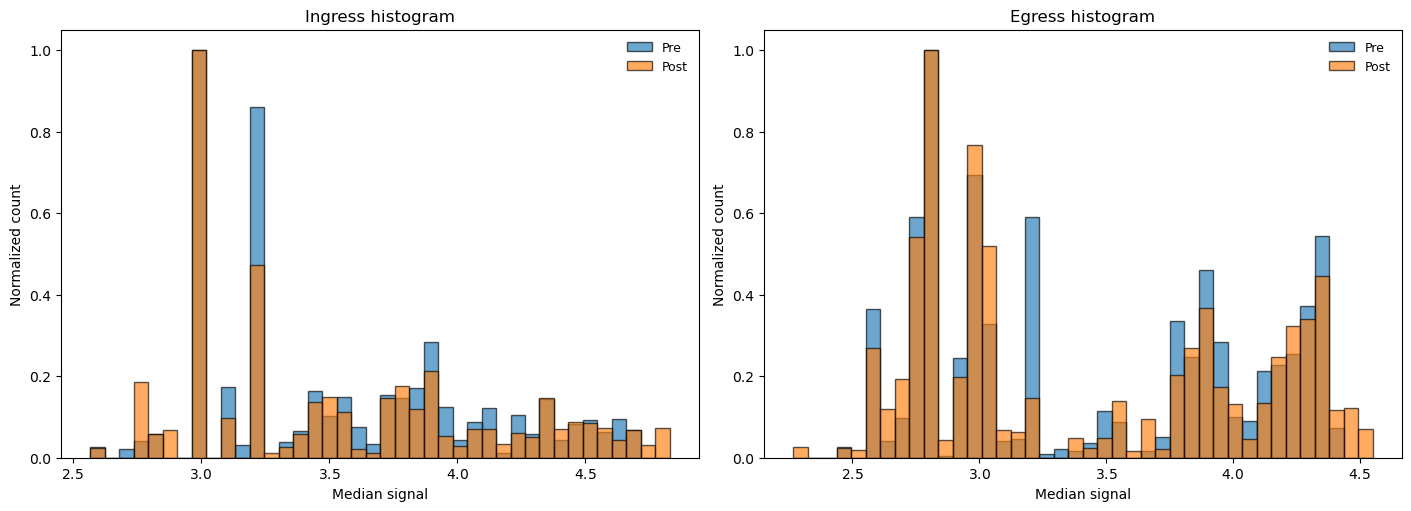

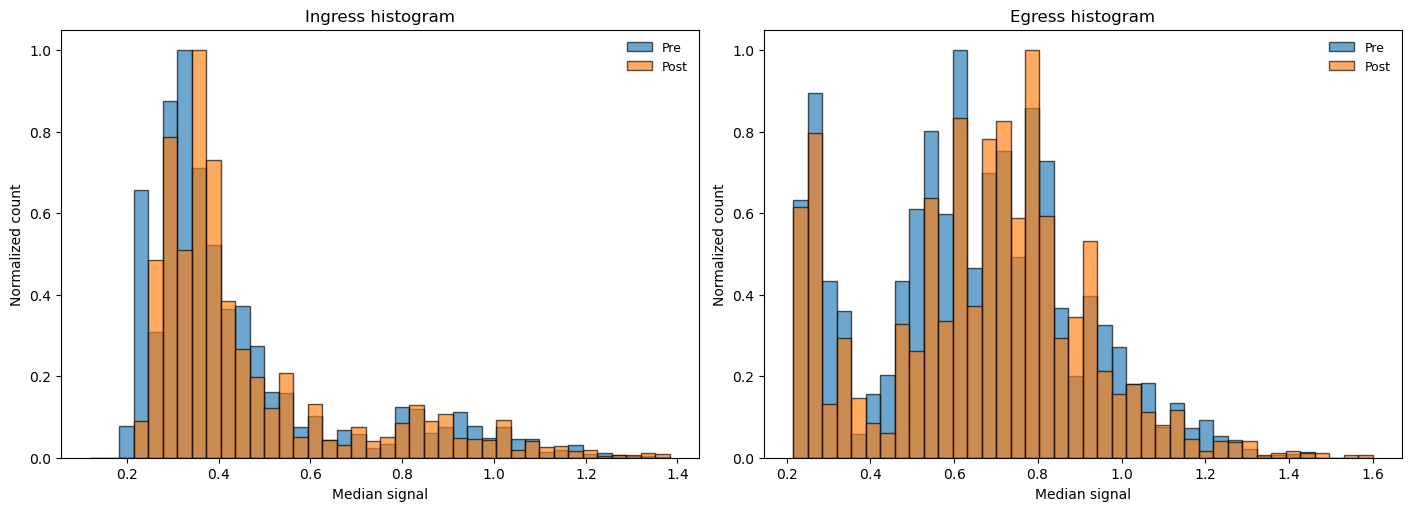

: 

In [ ]:
min_bin = [0.5,0.1,0.1,0.05,0.5,0.3,0.3,0.05,0.05]
for i in range(1,9):
    plotIngressEgressHistograms(stats[i],use_std_weights=True,min_bin_percentage=min_bin[i-1])

In [ ]:
binperc = [0.6,0.2,0.1,0.1,0.3,0.3,0.3,0.1,0.1]
for i in range(1,9):
    print(i)   
    plotIngressEgressDiffHistograms(stats[i],use_std_weights=True,min_bin_percentage=binperc[i-1])#dont let there be a bin at 0, clearly divide between negative and postive

1


NameError: name 'plotIngressEgressDiffHistograms' is not defined

: 

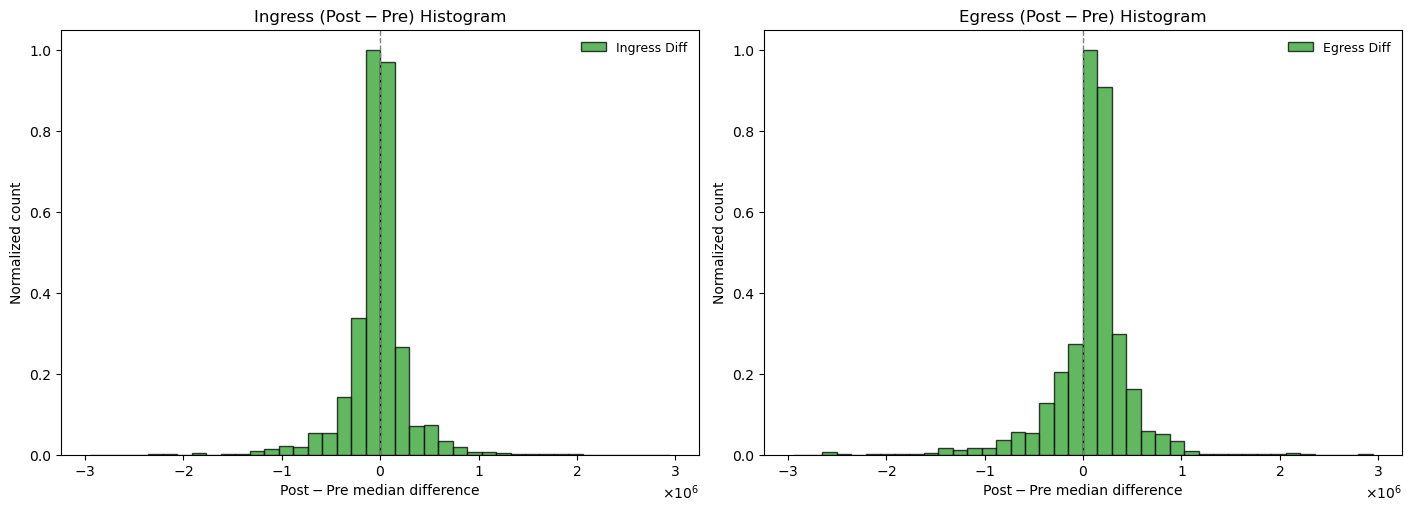

: 

In [ ]:
plotIngressEgressDiffHistograms(stats[2],use_std_weights=True,min_bin_percentage=0.3)#dont let there be a bin at 0, clearly divide between negative and postive

: 